In [ ]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None  )
pd.set_option('display.max_colwidth', None)

from scipy.optimize import curve_fit

def samples_seen_from_str(samples):
    if samples.endswith("M"):
        samples = float(samples[:-1]) * 10**6
    elif samples.endswith("B"):
        samples = float(samples[:-1]) * 10**9
    elif samples.endswith("K"):
        samples = float(samples[:-1]) * 10**3
    return samples

def powlaw_irreducible(x, a, b, c):
    return a * np.power(x, b) + c


def powlaw_chinchilla(x, a, alpha, b, c):
    # x is tuple n, d
    return c + a * np.power(x[0], alpha) + b * np.power(x[1], alpha)

def powlaw(x, a, b):
    return a * np.power(x, b)


def curve_fit_powlaw_irreducible(xdata, ydata):
    # try many different fits and retain the best one as done in chinchilla
    a_p0 = [5e1, 5e2, 5e3]
    b_p0 = [-1e-1]
    c_p0 = [0.0]

    min_residual = float("inf")
    ret = None

    for a0 in a_p0:
        for b0 in b_p0:
            for c0 in c_p0:
                popt, pcov = curve_fit(
                    powlaw_irreducible,
                    xdata,
                    ydata,
                    p0=[a0, b0, c0],
                    maxfev=10000,
                )

                ydatafit = powlaw_irreducible(xdata, *popt)
                residuals = ydata - ydatafit
                curr_residual = (np.sum(residuals**2) / (residuals.size - 2)) ** 0.5

                if curr_residual < min_residual:
                    min_residual = curr_residual
                    ret = (popt, pcov, ydatafit)

    def func(x):
        a,b,c = ret[0]
        return (a*x**b)
    a,b,c = ret[0]
    return (a,b,c), func, f"Y = {a:.4f}*X^{b:.4f}+{c:.4f}"

def curve_fit_powlaw_quantile(xdata, ydata, q=0.1):
    from sklearn.linear_model import QuantileRegressor, LinearRegression
    if q is None:
        r = LinearRegression()
    else:
        r = QuantileRegressor(quantile=q, alpha=0, solver='highs-ds')
    print(r)
    log_xdata = np.log(xdata)
    log_ydata = np.log(ydata)
    r.fit(log_xdata.reshape((-1, 1)), log_ydata)
    def func(x):
        return (x**r.coef_[0]) * np.exp(r.intercept_)
    a, b = (r.intercept_, r.coef_[0])
    return (a,b), func, f"Y = {np.exp(a):.4f} x X^{b:.4f}"

In [578]:
%%time
!python build_results_dataframe.py

Done loading results
Added sugar crepe avg
CPU times: user 3.34 s, sys: 585 ms, total: 3.92 s
Wall time: 5min 19s


In [579]:
df = pd.read_csv("results.csv")
model_profile = pd.read_csv("model_profile.csv").set_index("model")

In [581]:
print("Number of unique models: ", len(df.name.unique()))
print("Number of unique checkpoints: ", len(df.name_epoch.unique()))
print("Number of downstream datasets", len(df.downstream_dataset.unique()))
print("Number of evaluations", len(df))

Number of unique models:  1890
Number of unique checkpoints:  60137
Number of downstream datasets 12
Number of evaluations 209351


In [582]:
model_profile.head()

,image_size,image_width,text_width,embed_dim,mparams,image_mparams,text_mparams,gflops,image_gflops,text_gflops
model,,,,,,,,,,
ViT-S-32-alt,224,384.0,256.0,256.0,43.22,22.59,20.63,3.56,2.29,1.27
ViT-S-32,224,384.0,384.0,384.0,63.09,22.64,40.44,5.66,2.29,3.38
ViT-M-32-alt,224,512.0,384.0,384.0,80.07,39.63,40.44,7.37,3.99,3.38
ViT-M-32,224,512.0,512.0,512.0,103.12,39.69,63.43,9.95,3.99,5.96
ViT-S-16-alt,224,384.0,256.0,256.0,42.40,21.76,20.63,10.47,9.20,1.27


# Throughput 

In [583]:
df.model.unique()

array(['mammut_ViT-M-32', 'mammut_ViT-L-14', 'mammut_ViT-S-32',
       'mammut_ViT-B-32', 'mammut_ViT-S-16', 'mammut_ViT-H-14',
       'mammut_ViT-B-16', 'ViT-B-32', 'ViT-S-16', 'ViT-S-32',
       'coca_ViT-S-32', 'ViT-M-32', 'ViT-B-16-text-plus', 'coca_ViT-L-14',
       'coca_ViT-M-32', 'coca_ViT-S-16', 'coca_ViT-B-32', 'coca_ViT-B-16',
       'ViT-L-14', 'ViT-H-14', 'ViT-S-32-alt', 'ViT-B-16', 'ViT-M-16',
       'ViT-M-16-alt', 'ViT-M-32-alt'], dtype=object)

Text(0, 0.5, 'mparams')

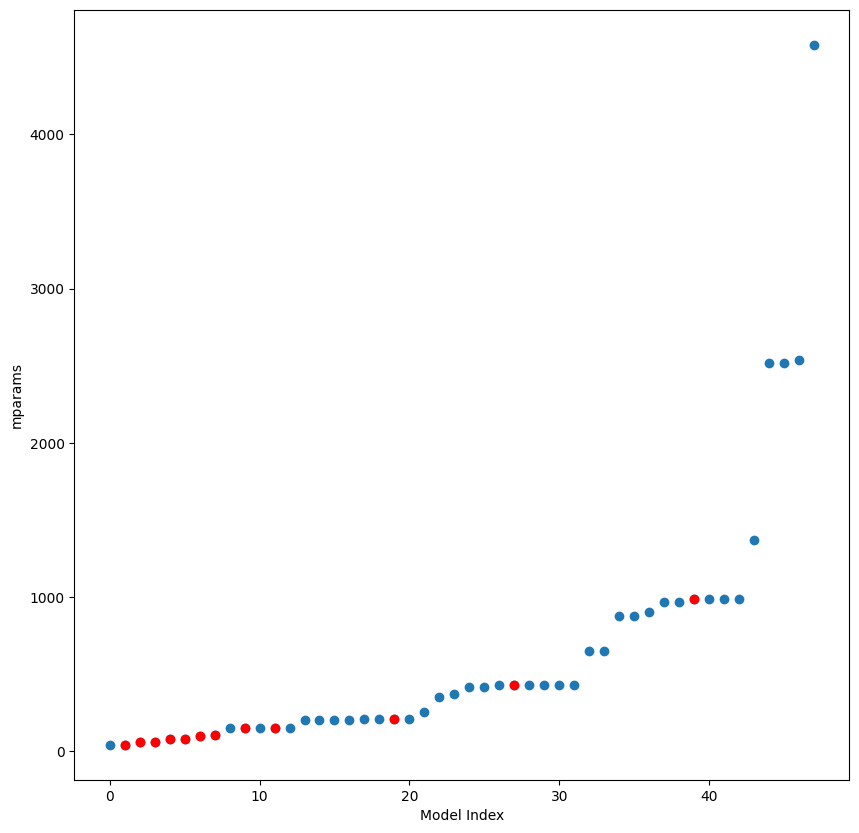

In [573]:
mp = model_profile.reset_index().copy()
mp = mp[mp["model"].str.startswith("ViT")]
S = "mparams"
mp = mp.sort_values(S)
mp["nb"] = np.arange(len(mp))

fig = plt.figure(figsize=(10, 10))

#mp.plot.scatter(x="nb", y="gflops")
plt.scatter(mp.nb, mp[S])

m = mp[mp.model.isin(df.model.unique())]
plt.scatter(m["nb"], m[S], c='red')
plt.xlabel("Model Index")
plt.ylabel(S)

In [574]:
model_profile.index

Index(['ViT-S-32-alt', 'ViT-S-32', 'ViT-M-32-alt', 'ViT-M-32', 'ViT-S-16-alt',
       'ViT-S-16', 'ViT-B-32', 'ViT-B-32-quickgelu', 'convnext_tiny',
       'ViT-B-32-256',
       ...
       'mammut_ViT-H-14', 'coca_ViT-S-32', 'coca_ViT-S-16', 'coca_ViT-M-32',
       'coca_ViT-B-16', 'ViT-SO150M-14-smaller-text', 'ViT-SO150M-14',
       'ViT-SO400M-14', 'sg_cap_ViT-B-32', 'sg_cap_ViT-B-16'],
      dtype='object', name='model', length=102)

<Axes: xlabel='model_s', ylabel='samples_per_sec_per_gpu'>

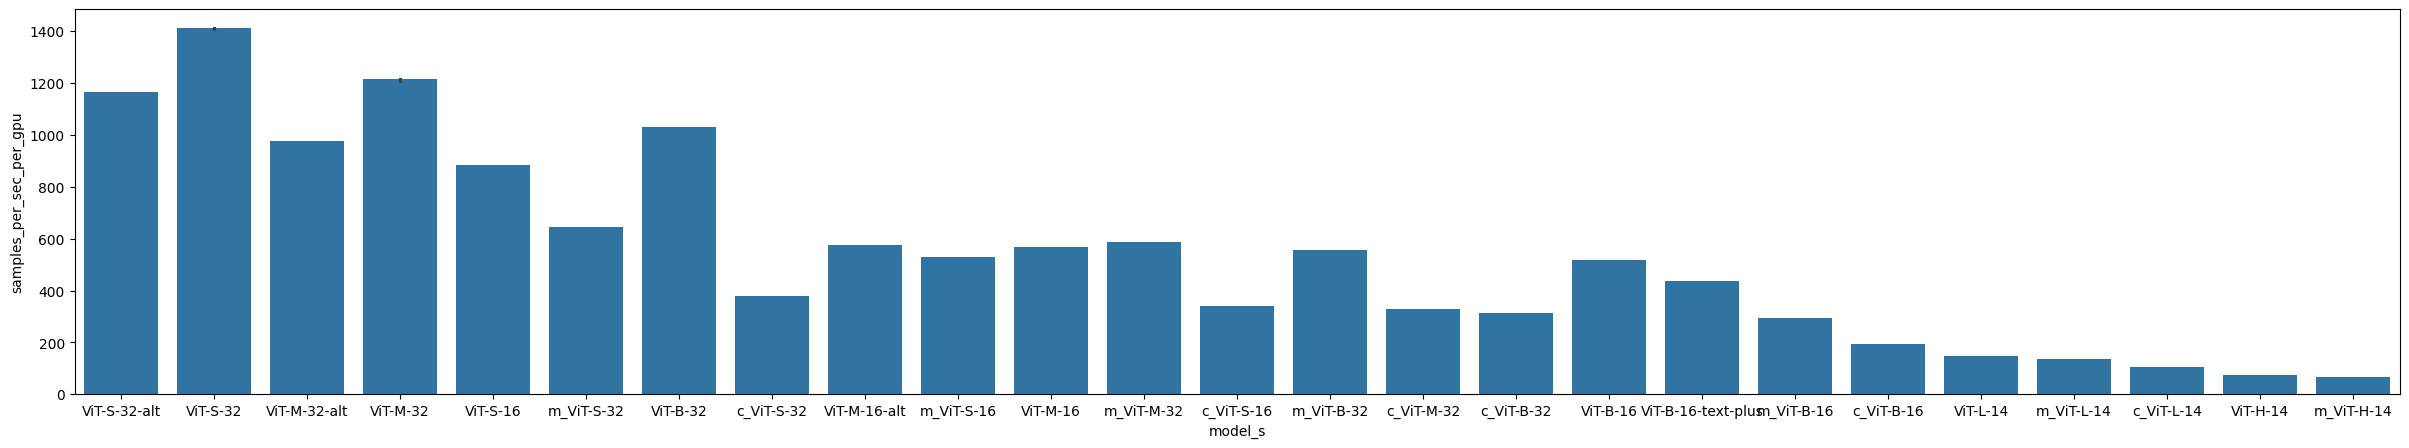

In [575]:
fig = plt.figure(figsize=(30, 5))
d = df.copy()
d["mparams"] = d.model.apply(lambda m:model_profile.loc[m].mparams)
d["gflops_model"] = d.model.apply(lambda m:model_profile.loc[m].gflops)

d["model_s"] = d.model.apply(lambda m:m.replace("mammut", "m").replace("coca", "c"))

archs = d.model_s.unique()

archs = sorted(archs, key=lambda k:model_profile.loc[k.replace("m", "mammut").replace("c", "coca")].gflops)

d["normalized_samples_per_sec_per_gpu"] = d["samples_per_sec_per_gpu"] / (d["local_batch_size"] * d["gpus"]) 
sns.barplot(x="model_s", y="samples_per_sec_per_gpu", data=d, order=archs, estimator=np.max)

In [584]:
d = df.copy()
d.groupby("model_simple_namespace").max("samples_per_sec_per_gpu").samples_per_sec_per_gpu.sort_values()

model_simple_namespace
ViT-H-14_mammut              55.467589
ViT-H-14_cap                 65.918173
ViT-H-14_clip                74.115664
ViT-L-14_coca               107.178987
ViT-L-14_mammut             118.440348
ViT-L-14_cap                135.658584
ViT-L-14_clip               149.465855
ViT-B-16_coca               195.494934
ViT-B-16_cap                294.591618
ViT-B-32_coca               313.512217
ViT-M-32_coca               327.108849
ViT-S-16_coca               338.673007
ViT-S-32_coca               380.128967
ViT-B-16_mammut             431.017696
ViT-B-16-text-plus_clip     436.032583
ViT-S-16_mammut             480.001876
ViT-B-16_clip               516.958750
ViT-S-16_cap                528.224919
ViT-B-32_cap                554.248881
ViT-M-16_clip               566.697109
ViT-M-16-alt_clip           576.878047
ViT-M-32_cap                586.268684
ViT-S-32_cap                645.252519
ViT-B-32_mammut             750.492644
ViT-M-32_mammut             809.746596
Vi

# DataComp Recap (recaptioned) vs DataComp results

In [585]:
#ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
#ds, metric = "winoground", "text_acc"
ds, metric = "winoground", "acc"

pretrain_datasets = df.pretrain_dataset.unique()
print(pretrain_datasets)

d = df[~df.pretrain_dataset.isna()].copy()
d["name_wo_ds"] = d.name.apply(lambda n:n.replace("datacomp_recap", "").replace("datacomp", ""))
ns = "cap"
d = d[d.namespace==ns]
df_recap = d[d.pretrain_dataset=="datacomp_1b_recap"]
df_orig = d[d.pretrain_dataset=="datacomp_1b"]
print(df_recap.namespace.unique())
print(df_orig.namespace.unique())

d = df_recap
d = d[d.epoch == d.total_epochs]
d = d[d.downstream_dataset == ds]


do = df_orig
do = do[do.epoch == do.total_epochs]
do = do[do.downstream_dataset == ds]
d = pd.merge(d, do, on="name_wo_ds", suffixes=("_recap", "_orig"))
d[["name_recap", f"{metric}_recap", f"{metric}_orig"]]

['datacomp_1b' 'datacomp_1b_recap']
['cap']
['cap']


,name_recap,acc_recap,acc_orig
0,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.0900,0.0775
1,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1075,0.0800
2,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1075,0.0700
3,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.0900,0.0650
4,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1000,0.0600
5,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.0900,0.0725
6,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1000,0.0750
7,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1025,0.0700
8,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,0.0900,0.0675
9,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,0.0925,0.0725


In [587]:
df[ (df.downstream_dataset=="imagenet1k") & (df.samples_seen_scale_pretty=="128M") & (df.total_epochs==df.epoch) & (df.model=="ViT-B-32")].sort_values(by="acc1", ascending=False)[["acc1", "name", "namespace", "epoch"]]

,acc1,name,namespace,epoch
107439,0.40396,datacomp_s128M_bs_8192_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n16_bs128_sigFalse,clip,20
103175,0.40292,datacomp_s128M_bs_8192_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs128_sigFalse,clip,20
47622,0.40286,datacomp_s128M_bs_8192_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs128_sigFalse,clip,20
73312,0.40248,datacomp_s128M_bs_8192_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n16_bs128_sigFalse,clip,20
104781,0.39684,datacomp_s128M_bs_8192_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w2000_gc1_n16_bs128_sigFalse,clip,20
86665,0.39204,datacomp_s128M_bs_8192_ViT-B-32_ep20_lr0.003_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n16_bs128_sigFalse,clip,20
110215,0.39070,datacomp_s128M_bs_8192_ViT-B-32_ep20_lr0.003_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs128_sigFalse,clip,20
80533,0.38732,datacomp_s128M_bs_8192_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w2000_gc1_n16_bs128_sigFalse,clip,20
67762,0.38052,datacomp_s128M_bs_8192_ViT-B-32_ep20_lr0.003_b1_0.9_b2_0.95_wd0.2_w2000_gc1_n16_bs128_sigFalse,clip,20
162782,0.10768,cooldown_s128M,clip,10


# Results per checkpoint

In [588]:
df[df.downstream_dataset=="imagenet1k"].sort_values(by="acc1", ascending=False).head()[["acc1", "name", "namespace", "epoch"]]

,acc1,name,namespace,epoch
107716,0.80342,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,99
107692,0.80338,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,100
107580,0.80298,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
107715,0.80294,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,98
80465,0.80232,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,98


In [589]:
df[ (df.downstream_dataset=="imagenet1k") & (df.namespace=="clip")].sort_values(by="acc1", ascending=False).head()[["acc1", "name", "namespace", "epoch"]]

,acc1,name,namespace,epoch
109073,0.76562,datacomp_s3B_bs_91136_ViT-L-14_ep48_lr0.004_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n128_bs178_sigFalse,clip,48
109062,0.76528,datacomp_s3B_bs_91136_ViT-L-14_ep48_lr0.004_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n128_bs178_sigFalse,clip,47
109134,0.76444,datacomp_s3B_bs_91136_ViT-L-14_ep48_lr0.004_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n128_bs178_sigFalse,clip,46
96725,0.76424,datacomp_s3B_bs_91136_ViT-L-14_ep48_lr0.002_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n128_bs178_sigFalse,clip,48
96714,0.76420,datacomp_s3B_bs_91136_ViT-L-14_ep48_lr0.002_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n128_bs178_sigFalse,clip,47


In [591]:
d = df
d = d[d.downstream_dataset=="imagenet1k"]
d = d[d.epoch==d.total_epochs]
d = d[d.samples_seen_scale_pretty=="12.8B"]
d = d[d.model_simple=="ViT-L-14"]
d = d.sort_values(by="acc1", ascending=False)[["acc1", "name", "namespace"]]
d

,acc1,name,namespace
107692,0.803380,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
95860,0.802260,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
80442,0.801680,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut
71927,0.801520,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut
49579,0.800700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
106074,0.800280,datacomp_s12.8B_bs_360960_mammut_ViT-L-14_ep100_lr0.0035_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n320_bs282_sigFalse,mammut
84490,0.799060,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0015_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
86814,0.798600,datacomp_s12.8B_bs_90112_mammut_ViT-L-14_ep100_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n176_bs128_sigFalse,mammut
80242,0.796100,datacomp_s12.8B_bs_90112_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n176_bs128_sigFalse,mammut
87014,0.793400,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut


In [592]:
df[df.downstream_dataset=="sugar_crepe"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
205978,0.910728,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,19
205986,0.910250,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,20
205983,0.905062,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,18
208260,0.903457,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,20
205996,0.903354,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,17


In [593]:
df[df.downstream_dataset=="sugar_crepe/swap_obj"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
71592,0.869919,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,92
71814,0.869919,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,100
71924,0.865854,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,99
72037,0.865854,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,97
8236,0.865854,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,19


In [595]:
df[df.downstream_dataset=="winoground"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
49302,0.1425,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,88
4495,0.1400,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
4381,0.1375,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,20
49285,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
49200,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,93


In [596]:
df[df.downstream_dataset=="winoground"].sort_values(by="text_acc", ascending=False).head(20)[["text_acc", "name", "namespace", "epoch"]]

,text_acc,name,namespace,epoch
71670,0.3800,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,40
71944,0.3700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,70
71787,0.3700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,93
71980,0.3650,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,94
71941,0.3600,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,91
49739,0.3575,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,63
71635,0.3550,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,86
71874,0.3550,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,82
71742,0.3525,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,80
71802,0.3525,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,45


In [597]:
df[df.downstream_dataset=="winoground"].sort_values(by="image_acc", ascending=False).head()[["image_acc", "name", "namespace", "epoch"]]

,image_acc,name,namespace,epoch
9837,0.2475,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,19
9748,0.2425,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,16
22009,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
10086,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,6
2076,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,13


# Specific Training Curves

['mammut']
        epoch     acc1
107626      1  0.03620
107735      2  0.13246
107722      3  0.29714
107632      4  0.45868
107690      5  0.54422
107684      6  0.58412
107608      7  0.61342
107633      8  0.63158
107705      9  0.64074
107604     10  0.65838
107605     11  0.66094
107653     12  0.67064
107630     13  0.66980
107647     14  0.67176
107645     15  0.68334
107618     16  0.67928
107581     17  0.67566
107689     18  0.68776
107650     19  0.69326
107609     20  0.68664
107654     21  0.69520
107700     22  0.69382
107612     23  0.69168
107607     24  0.69526
107637     25  0.68896
107564     26  0.70040
107640     27  0.69620
107671     28  0.70430
107571     29  0.70330
107644     30  0.70102
107596     31  0.70592
107568     32  0.70224
107712     33  0.70754
107691     34  0.70798
107597     35  0.70426
107748     36  0.71136
107740     37  0.71382
107624     38  0.71618
107593     39  0.71072
107754     40  0.71190
107736     41  0.71660
107756     42  0.71780


Text(0.5, 1.0, 'imagenet1k acc1 zeroshot_classification')

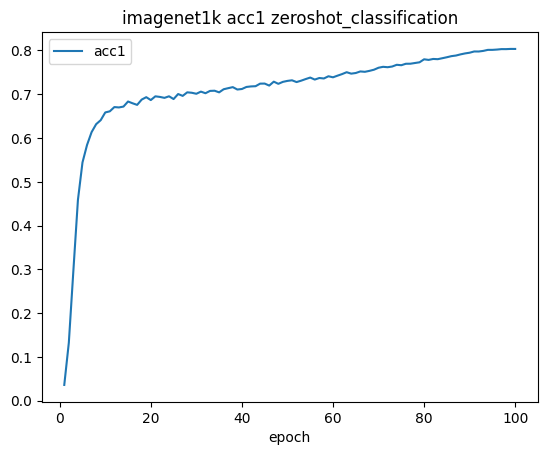

In [598]:
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n256_bs176_sigFalse_consw0_cw1"
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0015_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n256_bs176_sigFalse_consw0_cw1"
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n256_bs176_sigFalse_consw0_cw1"

name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"

#ds, metric, task = "winoground", "image_acc", "generative_image_caption_selection"
#ds, metric, task = "winoground", "text_acc", "generative_image_caption_selection"
#ds, metric, task = "sugar_crepe/swap_obj", "acc", "generative_image_caption_selection"
ds, metric, task = "imagenet1k", "acc1", "zeroshot_classification"
#ds, metric, task = "imagenet1k", "acc1", "generative_zeroshot_classification"

d = df

d = d[d.name==name]
d = d[d.task == task]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
print(d.namespace.unique())
print(d[["epoch", metric]])
#print(d[["epoch", metric]])
d.plot(x="epoch", y=metric)
#d[["epoch", metric]]
plt.title(f"{ds} {metric} {task}")

Text(0.5, 1.0, 'winoground generative_image_caption_selection text_acc')

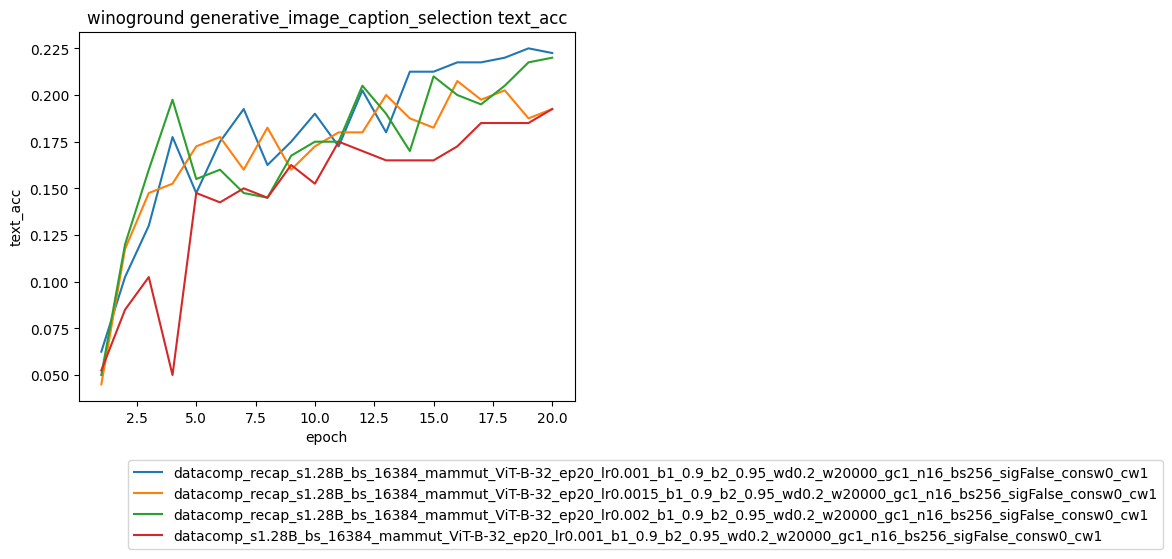

In [599]:
ds, metric, task = "winoground", "text_acc", "generative_image_caption_selection"
#ds, metric, task = "sugar_crepe/swap_obj", "acc", "generative_image_caption_selection"
#ds, metric, task = "imagenet1k", "acc1", "zeroshot_classification"
#ds, metric, task = "imagenet1k", "acc1", "generative_zeroshot_classification"


#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1"
names = [
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
]

d = df

d = d[d.name.isin(names)]
d = d[d.task == task]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="name", data=d)
#d[["epoch", metric]]
plt.legend(loc=(.1,-.4))
plt.title(f"{ds} {task} {metric}")

Text(0.5, 1.0, 'winoground')

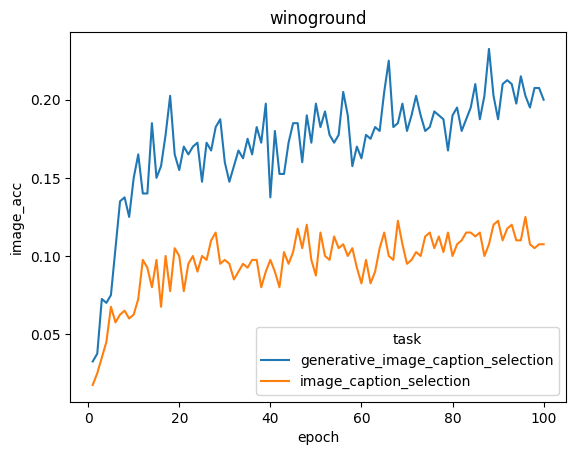

In [600]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
ds = "winoground"
metric = "image_acc"

d = df

d = d[d.name==name]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="task", data=d)
plt.title(f"{ds}")

Text(0.5, 1.0, 'winoground')

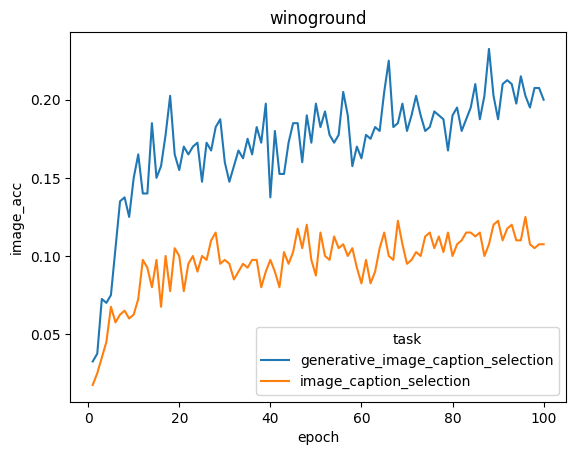

In [601]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
ds = "winoground"
metric = "image_acc"

d = df

d = d[d.name==name]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="task", data=d)
plt.title(f"{ds}")

# Full results table

In [602]:
ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
#ds, metric = "winoground", "text_acc"
d = df
d = d[d.pretrain_dataset=="datacomp_1b"]
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
#d = d[d.task == "generative_image_caption_selection"]
#d = d[d.task == "generative_zeroshot_classification"]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_pretty", "model_simple_namespace")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_pretty",
    columns=("model_simple_namespace"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-1])].gflops)

d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
d = d.loc[index]

dl = d.T.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
d
d.T

samples_seen_scale_pretty,1.28M,3M,6.4M,12.8M,30M,64M,128M,300M,1.28B,3B,12.8B
model_simple_namespace,,,,,,,,,,,
ViT-S-32-alt_clip,NaN,NaN,NaN,NaN,NaN,NaN,0.070020,NaN,0.488420,0.53172,0.566800
ViT-S-32_cap,0.002769,NaN,NaN,0.044304,NaN,NaN,0.163172,NaN,0.305973,NaN,NaN
ViT-S-32_clip,0.014460,0.03098,0.06208,0.104220,0.18664,NaN,0.354020,0.48916,0.531180,0.55864,0.595860
ViT-S-32_coca,0.015120,0.03340,NaN,0.113140,0.20104,NaN,0.358120,0.44002,NaN,NaN,NaN
ViT-S-32_mammut,0.014520,0.03340,0.06400,0.113840,0.20358,0.29304,0.372280,0.50264,0.514200,0.56516,NaN
ViT-M-32-alt_clip,NaN,NaN,NaN,NaN,NaN,NaN,0.080700,NaN,0.550780,0.59182,0.630680
ViT-M-32_cap,0.003362,NaN,NaN,0.042326,NaN,NaN,0.204114,NaN,0.364715,NaN,NaN
ViT-M-32_clip,0.015460,0.03240,0.06340,0.113220,0.20074,NaN,0.383020,0.52716,0.573040,0.60788,0.642120
ViT-M-32_coca,0.016000,0.03114,NaN,0.119780,0.21860,NaN,0.388160,0.47972,NaN,NaN,NaN


In [604]:
#ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
ds, metric = "winoground", "text_acc"
#ds, metric = "winoground", "acc"
d = df
d = d[d.pretrain_dataset=="datacomp_1b"]
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]

d = d[d.samples_seen_scale_pretty == "12.8B"]

d = d[d.namespace.isin(["mammut", "cap"])]
d = d.sort_values(by=metric, ascending=False)
d["eval_type"] = d.task.apply(lambda t:"(L)" if "generative" in t else "(E)")



d["model_simple_eval_type"] = d.model_simple + " " + d.eval_type
d["namespace_eval_type"] = d.namespace + " " + d.eval_type
vars=("samples_seen_scale_pretty", "model_simple", "namespace", "eval_type")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="namespace_eval_type",
    columns=("model_simple"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc[k.replace("(E)", "").replace("(L)", "").strip()].gflops)

cols = [c for c in cols if "H-14" not in c and "plus" not in c]
d = d[cols]
index = sorted(d.index, key=lambda k:k[-2])[::-1]
#index = ["cap(L)", "mammut(L)", "mammut(E)"]

d = d.loc[index]

dl = d.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
#d
#d.T
#print(s) 
#print(s)

# Const-Cooldown results

In [605]:
ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
#ds, metric = "winoground", "text_acc"
d = df.copy()
d["model_simple_namespace_scheduler"] = d.apply(lambda r:f"{r.model_simple_namespace}_{r.lr_scheduler}", axis=1)
d = d[d.pretrain_dataset == "datacomp_1b"]
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
d = d[d.lr_scheduler.isin(["cosine", "const-cooldown"])]
d = d[d.namespace == "clip"]
#d = d[d.task.str.contains("generative")]
#print(len(d))
#d = d[d.eval_type == eval_type]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_pretty", "model_simple_namespace_scheduler")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_pretty",
    columns=("model_simple_namespace_scheduler"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-2])].gflops)
#cols = [c  for c in cols if "cap" not in c and "coca" not in c and "H-14" not in c and "plus" not in c]

d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
#index = ['1.28B']
d = d.loc[index]
#print(index)
#d = d.dropna(axis=0)
#d.T

dl = d.T.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
d
d.T

samples_seen_scale_pretty,1.28M,3M,6.4M,12.8M,30M,128M,300M,1.28B,3B,12.8B
model_simple_namespace_scheduler,,,,,,,,,,
ViT-S-32-alt_clip_const-cooldown,NaN,NaN,NaN,NaN,NaN,0.07002,NaN,0.48842,0.53172,0.56680
ViT-S-32_clip_const-cooldown,0.01446,0.03098,0.06208,0.10422,NaN,0.07572,0.48916,0.51138,0.55742,0.59586
ViT-S-32_clip_cosine,0.01304,0.03032,NaN,0.10208,0.18664,0.35402,0.43956,0.53118,0.55864,NaN
ViT-M-32-alt_clip_const-cooldown,NaN,NaN,NaN,NaN,NaN,0.08070,NaN,0.55078,0.59182,0.63068
ViT-M-32_clip_const-cooldown,0.01546,0.03216,0.06340,0.11322,NaN,0.09260,0.52716,0.56184,0.60714,0.64212
ViT-M-32_clip_cosine,0.01396,0.03240,NaN,0.10504,0.20074,0.38302,0.47810,0.57304,0.60788,NaN
ViT-S-16_clip_const-cooldown,NaN,NaN,NaN,NaN,NaN,0.09390,NaN,0.58546,0.62614,0.66382
ViT-S-16_clip_cosine,0.02000,0.04404,NaN,0.13388,0.23700,0.42338,0.50486,0.59574,0.62844,NaN
ViT-B-32_clip_const-cooldown,0.01496,0.03382,0.06836,0.11818,NaN,0.10768,0.56020,0.60546,0.65276,0.68860


# Comparison between Log-likehood and Similarity based evaluation

array(['datacomp_1b', 'datacomp_1b_recap'], dtype=object)

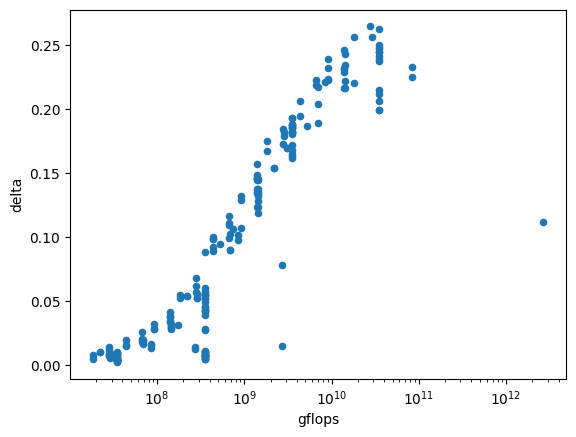

,generative_zeroshot_classification,zeroshot_classification,delta,gflops
50,0.688739,0.80070,0.111961,2.685952e+12
150,0.429188,0.65380,0.224612,8.398848e+10
151,0.398318,0.63082,0.232502,8.398848e+10
1,0.404991,0.61630,0.211309,3.499520e+10
0,0.401335,0.61618,0.214845,3.499520e+10


In [608]:
ds, metric, task = "imagenet1k", "acc1", "zeroshot_classification"
#ds, metric, task = "sugar_crepe/swap_obj", "acc", "image_caption_selection"
#ds, metric, task = "winoground", "text_acc", "image_caption_selection"
#ds, metric, task = "winoground", "image_acc", "image_caption_selection"

d = df.copy()
d = d[d.pretrain_dataset=="datacomp_1b"]


gtask = "generative_" + task
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
di = d[d.task==task]
d["name_wo_task"] = d.apply(lambda r:r["name"].replace("generative_", ""), axis=1)
d = d.drop_duplicates(subset=["name_wo_task", "task"], keep="first")    
d = pd.pivot(
    d,
    index="name_wo_task",
    columns=("task"),
    values=metric,
)
d = d.dropna(axis=0)
d["delta"] = (d[task] - d[gtask]).abs()
d = pd.merge(d, di, left_on='name_wo_task', right_on="name")
d = d.sort_values(by=task, ascending=False)#.head()
#print(d[[gtask, task, "delta", "gflops_total"]].head())
d.plot(x="gflops", y="delta", kind="scatter")
plt.xscale('log',base=10)
plt.show()
d[[gtask, task, "delta", "gflops"]].head()

# Scaling law figures

In [ ]:
import torch
import math
def monotonically_decreasing(x):
    m = []
    minval = float("inf")
    for xi in x:
        if xi < minval:
            m.append(True)
            minval = xi
        else:
            m.append(False)
    return np.array(m)

def monotonically_increasing(x):
    m = []
    maxval = float("-inf")
    for xi in x:
        if xi > maxval:
            m.append(True)
            maxval = xi
        else:
            m.append(False)
    return np.array(m)

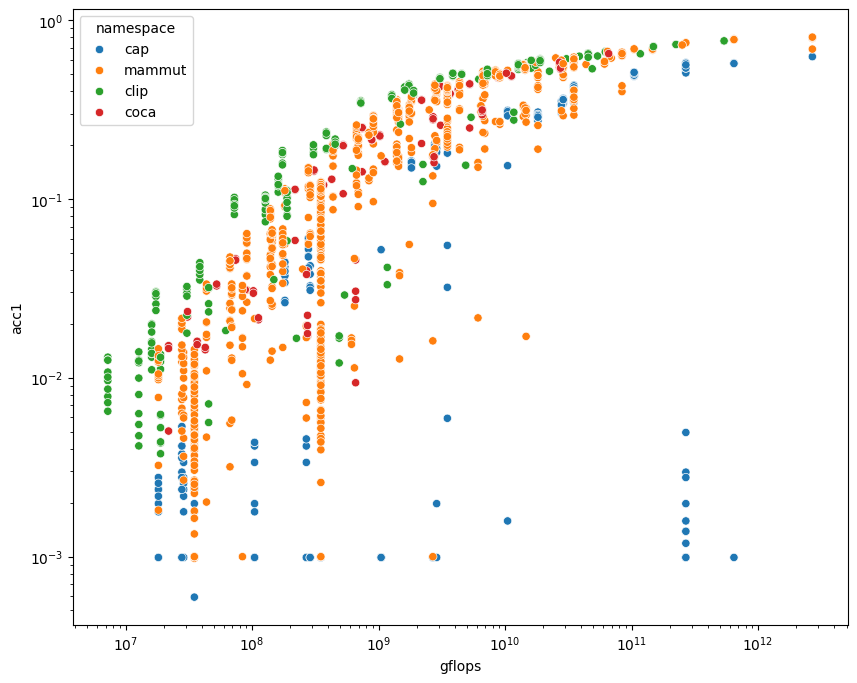

In [610]:
ds, metric = "imagenet1k", "acc1"
#scheduler = "const"
#ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
fig = plt.figure(figsize=(10, 8))
D = df
scheduler = "cosine"
D = D[D.pretrain_dataset == "datacomp_1b"]
if scheduler != "const":
    D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[D.lr_scheduler==scheduler]
D = D[~D[metric].isna()]
sns.scatterplot(x="gflops", y=metric, data=D, hue="namespace",)
plt.xscale('log',base=10)
plt.yscale('log',base=10)

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 7.5073 x X^-0.1094
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 14.9698 x X^-0.1544
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 5.2989 x X^-0.0900
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 17.6460 x X^-0.1573
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 8.1255 x X^-0.1140
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 22.3274 x X^-0.1702
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 9.4394 x X^-0.1261
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 6.9046 x X^-0.1105


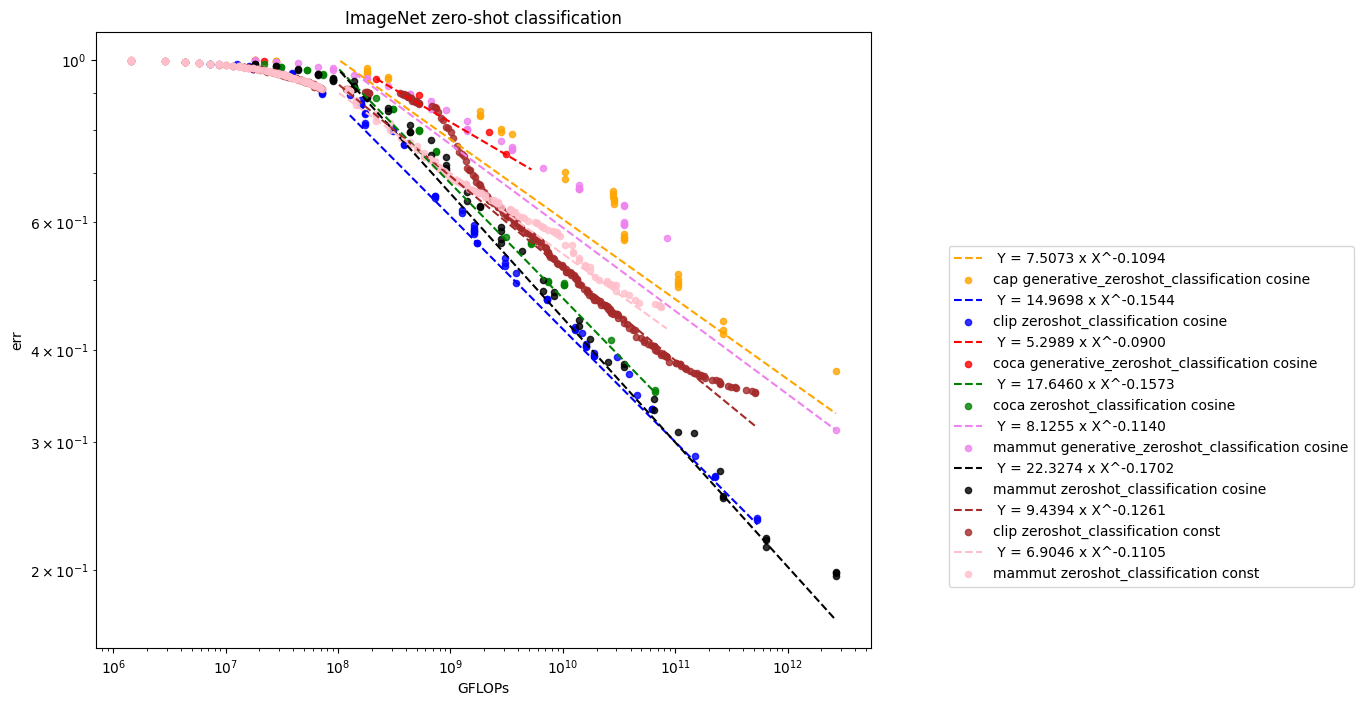

In [612]:
ds, metric = "imagenet1k", "acc1"
#scheduler = "const"
#ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
fig = plt.figure(figsize=(10, 8))
I = 0
colors = ["orange", "blue", "red", "green", "violet", "black", "brown", "pink", "gray", "cyan"]
curves = {}
for scheduler in ("cosine", "const", "const_cooldown"):
    D = df
    D = D[D.pretrain_dataset == "datacomp_1b"]
    if scheduler != "const":
        D = D[D.epoch==D.total_epochs]
    D = D[D.downstream_dataset==ds]
    D = D[D.lr_scheduler==scheduler]
    D = D[~D[metric].isna()]
    #D = D[D.namespace == "clip"]
    
    
    #print(D)
    for ind, (name, rows) in enumerate(D.groupby(["namespace", "task"])):    
        #if "generative"  in name[1]:
        #    continue
        #if "coca" in name[0]:
        #    continue
        #if "mammut" not in name[0]:
        #    continue
        R = rows[rows.downstream_dataset==ds]
        R = R[~R[metric].isna()]
        if len(R) == 0:
            continue
        R = R.sort_values(by="gflops")        
        X = (R["gflops"]).values
        Y = 1-(R[metric]).values


        color = colors[I]
        I+=1
        #m  = X>=10**9
        m = (X>=10**8)# & (X < 10**12)
        #m = (X<10**12)
        #m = (X>0)  & (Y<1)
        #m = X>0
        #print(np.unique(X))
        #for xi in np.unique(X):
        #    minval = Y[X==xi].min()
        #    Y[X==xi] = minval
        #m=(Y<=0.9) & (Y>0)
        coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
        
        curves[ (name[0], name[1], scheduler)] = func

        print(eq)
        plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)
        
        #X = X[Y<1]
        #Y = Y[Y<1]
        m = monotonically_decreasing(Y)
        #m = X>0
        plt.scatter(X[m], Y[m], label=f"{name[0]} {name[1]} {scheduler}", c=color, s=20.0, alpha=0.8)

        #plt.plot(X[m], Y[m], linestyle='dashed', c=color)
plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
plt.legend(loc=(1.1,.1))

#plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

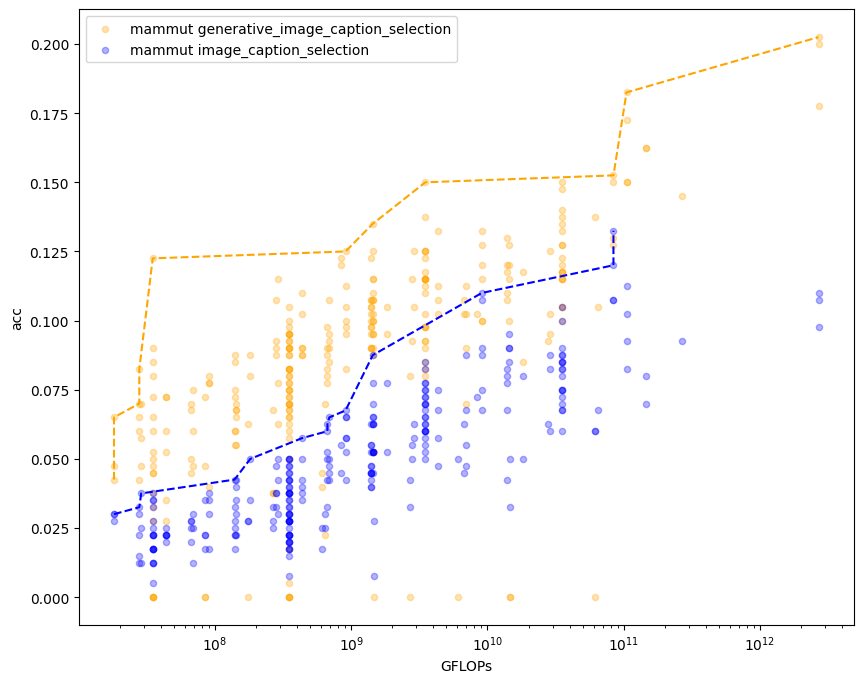

In [ ]:
#ds, metric = "imagenet1k", "acc1"
#ds, metric = "winoground", "text_acc"
ds, metric = "winoground", "image_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
#ds, metric = "sugar_crepe", "acc"
#ds, metric = "winoground", "acc"

D = df
D = D[D.pretrain_dataset == "datacomp_1b"]

D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
D = D[D.namespace.isin(["mammut"])]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby(["namespace", "task"])):    
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    R = rows[rows.downstream_dataset==ds]
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops")
    X = (R["gflops"]).values
    #Y = 1-(R[metric]).values
    Y = (R[metric]).values

    color = colors[I]
    I+=1
    #m = (X>=10**9)# & (X < 10**12)
    #m = (X<10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    #for xi in np.unique(X):
    #    minval = Y[X==xi].min()
    #    Y[X==xi] = minval
    #m=(Y<=0.9) & (Y>0)
    #coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    #plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)
    
    #X = X[Y<1]
    #Y = Y[Y<1]

    m = X>0
    plt.scatter(X[m], Y[m], label=f"{name[0]} {name[1]}", c=color, s=20.0, alpha=0.3)
    m = monotonically_increasing(Y)
    plt.plot(X[m], Y[m], linestyle='dashed', c=color)
    
plt.xscale('log')
#plt.yscale("log")

plt.xlabel("GFLOPs")

#plt.ylabel("err")  
plt.ylabel("acc")
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

In [615]:
import autograd.numpy as np
from autograd.scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf

true_params = np.array([np.log(406.4), np.log(410.7), np.log(1.69), 0.34, 0.28])

# Define the log-sum-exp function
def log_sum_exp(a, b, e, alpha, beta, N, D):
    return np.log(np.exp(a - alpha * np.log(N)) + np.exp(b - beta * np.log(D)) + np.exp(e))

# Define the Huber loss function
def custom_huber_loss(y_true, y_pred, delta=1e-3):
    # Calculate the difference
    diff = y_true - y_pred
    # Calculate the condition for Huber loss
    cond = np.abs(diff) <= delta
    # Apply Huber loss formula
    loss = np.where(cond, 0.5 * diff**2, delta * (np.abs(diff) - 0.5 * delta))
    return np.sum(loss)

def huber_normalizing_factor(delta=1e-3):
    return np.sqrt(2*np.pi) * (1 - 2*norm.sf(delta)) + 2 * np.exp(-0.5*delta**2)/delta

def huber_logpdf(x, delta=1e-3, loc=0, scale=1):
    x = (x-loc)/scale

    cond = np.abs(x) <= delta
    loss = np.where(cond, 0.5 * x**2, delta * (np.abs(x) - 0.5 * delta))
    return -loss - np.log(huber_normalizing_factor(delta=delta)) - np.log(scale)

def huber_pdf(x, delta=1e-3, loc=0, scale=1):
    return np.exp(huber_logpdf(x, delta=delta, loc=loc, scale=scale))

# Define the objective function to be minimized
def objective(params, N, D, losses):
    a, b, e, alpha, beta, sigma = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3))
    # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)

def scale_objective(sigma, params, N, D, losses):
    a, b, e, alpha, beta = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3))
    # return custom_huber_loss(np.log(losses), predictions, delta=1e-3)

def constant_term_objective(params, a, b, alpha, beta, N, D, losses):
    e, sigma = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return -np.sum(huber_logpdf(np.log(losses), loc=predictions, scale=np.exp(sigma), delta=1e-3))

def huber_loss_objective(params, N, D, losses):
    a, b, e, alpha, beta = params
    predictions = log_sum_exp(a, b, e, alpha, beta, N, D)
    return custom_huber_loss(np.log(losses), predictions, delta=1e-3)

# Define the parameter untransform
def untransform_params(param_array):
    if len(np.shape(param_array)) == 2:
      return np.hstack((np.exp(param_array[:, :3]), param_array[:, 3:]))
    else:
      return np.hstack((np.exp(param_array[:3]), param_array[3:]))

# Define the Huber loss function on residuals
def huber_loss(residuals, delta=1e-3):
    # Calculate the difference
    diff = residuals
    # Calculate the condition for Huber loss
    cond = np.abs(diff) <= delta
    # Apply Huber loss formula
    loss = np.where(cond, 0.5 * diff**2, delta * (np.abs(diff) - 0.5 * delta))
    return loss


def curve_fit_chinchilla_bfgs(X, Y):
    import autograd.numpy as np
    from scipy.optimize import minimize
    N = X[0]
    D = X[1]
    losses = Y
    # Set up the grid for initial parameter values
    alpha_vals = np.arange(0, 2.5, 0.5)
    beta_vals = np.arange(0, 2.5, 0.5)
    e_vals = np.arange(-1, 1.5, 0.5)
    a_vals = np.arange(0, 30, 5)
    b_vals = np.arange(0, 30, 5)

    # Perform the optimization using L-BFGS over the grid of initial values
    best_loss = np.inf
    best_params = None

    from itertools import product
    results_dict = {}
    for alpha, beta, e, a, b in product(alpha_vals, beta_vals, e_vals, a_vals, b_vals):
        init_params = [a, b, e, alpha, beta]
        result = minimize(huber_loss_objective, init_params, args=(N, D, losses), method='L-BFGS-B')
        results_dict[tuple(init_params)] = {'params': result.x, 'loss': result.fun}
        if result.success and result.fun < best_loss:
            best_loss = result.fun
            best_params = result.x
            print(f"New best loss: {best_loss}")
            print(f"Best params: {best_params}")
            print(f"Initial guess: {init_params}")

    # Transform the fitted parameters a, b, e to A, B, E
    if best_params is not None:
        print(best_params)
        A = np.exp(best_params[0])
        B = np.exp(best_params[1])
        E = np.exp(best_params[2])
        alpha = best_params[3]
        beta = best_params[4]
        print(f"Best fit parameters: A={A}, B={B}, E={E}, alpha={alpha}, beta={beta}")
    else:
        print("Optimization failed to converge.")
    return (A, B, E, alpha, beta), np.abs(powlaw_chinchilla(X, A, B, E, alpha, beta) - Y).mean()

from itertools import product

import cma
cma.CMAOptions('scale')

def get_patch_size(model_name):
    toks = model_name.split("-")
    #print(model_name)
    if model_name.endswith("alt"):
        ps = int(toks[-2])
    elif model_name.endswith("text-plus"):
        ps = int(toks[-3])
    else:
        ps = int(toks[-1])
    return ps

def powlaw_chinchilla(x, a, b, c, alpha, beta):
    M, D = x[0], x[1]
    return (c +  a * np.power(M, -alpha) + b * np.power(D, -beta))


def curve_fit_chinchilla_cma(xdata, ydata, nb_iterations=1000, nb_restarts=10):
    def loss(params):
        ydatafit = powlaw_chinchilla(xdata, *params)
        #return (np.abs(ydata - ydatafit) / ydata).mean()
        return np.abs(ydata - ydatafit).mean()
        #return (np.log(ydata) - np.log(ydatafit)).mean()
        # Alternatively, you could use squared error:
        #residuals = ydata - ydatafit
        #return np.sum(residuals**2) / (residuals.size - 2)

    best_params = None
    best_loss = float('inf')
    
    # Loop for the desired number of restarts
    for i in range(nb_restarts):
        # Initial guess
        initial_guess = [1, 1, 0, 0.01, 0.01]
        # Create a new CMAEvolutionStrategy instance with the initial guess and sigma value
        es = cma.CMAEvolutionStrategy(initial_guess, 1, {'AdaptSigma': cma.sigma_adaptation.CMAAdaptSigmaTPA})
        # Use maxiter to set the number of iterations for this run
        es.optimize(loss, iterations=nb_iterations)
        
        # Check if this run gives a better result
        if es.result.fbest < best_loss:
            best_loss = es.result.fbest
            best_params = es.result.xbest
            
    return best_params, best_loss

(0.23438000000000003, 0.99624)

In [616]:
scheduler = "const"
ds, metric = "imagenet1k", "acc1"
#ds, metric = "winoground", "text_acc"
#ds, metric = "winoground", "image_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
#ds, metric = "sugar_crepe", "acc"
#ds, metric = "winoground", "acc"
d = df
d = d[d.pretrain_dataset == "datacomp_1b"]
if scheduler != "const":
    d = d[d.epoch==d.total_epochs]
d = d[d.downstream_dataset==ds]
d = d[d.namespace.isin(["clip"])]
d = d[d.task.isin(["zeroshot_classification"])]
d = d[d.lr_scheduler==scheduler]
d = d.sort_values(by="gflops")
M_flops = ((d["model"].apply(lambda m:model_profile.loc[m].gflops).values) * 10**9)
M_params = ((d["model"].apply(lambda m:model_profile.loc[m].mparams).values) * 10**6)
M_context_length = (d.model.apply(lambda m:  (224//get_patch_size(m))**2  )).values
N = M_params
D = ((d["samples_seen"].values)) * M_context_length
G = N * D
Y = 1-(d[metric]).values
#Y = d["contrastive_loss"].values
X = np.stack((N, D), axis=1)
#param, loss = curve_fit_chinchilla_bfgs(X.T, Y)
param, loss = curve_fit_chinchilla_cma(X.T, Y)
print(param, loss)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=294272, Fri Feb 21 19:10:05 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.578549034521480e-01 1.0e+00 9.37e-01  9e-01  9e-01 0:00.0
    2     16 2.456368602014638e-01 1.2e+00 9.33e-01  8e-01  9e-01 0:00.0
    3     24 2.268448009357151e-01 1.2e+00 9.93e-01  9e-01  9e-01 0:00.0
  100    800 1.596159842329067e-01 2.0e+03 7.84e-03  3e-06  5e-03 0:00.8
NOTE (module=cma, iteration=124):  
condition in coordinate system exceeded 1.5e+08, rescaled to 1.0e+00, 
condition changed from 1.6e+08 to 1.0e+02
  186   1488 1.596159838987298e-01 3.7e+02 1.30e-02  5e-09  1e-02 0:01.5
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=196024, Fri Feb 21 19:10:08 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 9.454445800019559e+01 1.0e+00 9.37e-01  8e-01  9e-01 0:00.0
    2     16 1.013518409065125e+00 1.3e+00 8.40e-01  7e-01  8e-01 0:00.0
    3     24 1.6

In [617]:
print(np.log10(G.min()), np.log10(G.max()))
print(np.log10(N.min()), np.log10(N.max()))

14.898396572746346 20.57445569141168
7.635684762547222 8.179781515836984


181.47914471933962 4.739973932599313 -0.46601405521969175 0.3809664381261304 0.06782470859913502


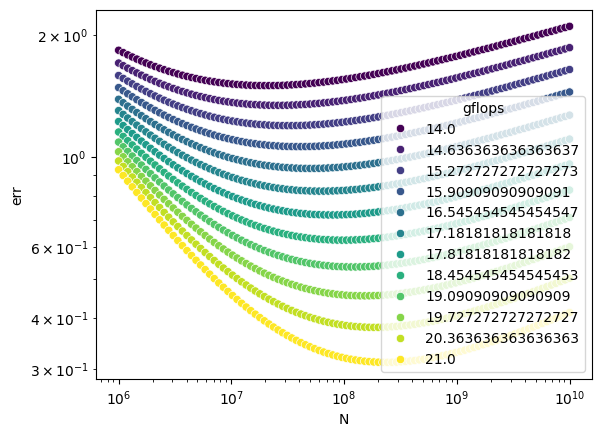

In [627]:
import seaborn as sns
A, B, C, alpha, beta = param
print(A, B, C, alpha, beta)
gflops_grid = np.logspace(14, 21, 12, base=10)
rows = []
NS = np.logspace(6, 10, 100)
for gflops in gflops_grid:
    for n in NS:
        d = gflops / (n)
        rows.append({"gflops": gflops, "N": n, "D": d})
CC = pd.DataFrame(rows)
CC["err"] = powlaw_chinchilla(CC[["N", "D"]].values.T, A, B, C, alpha, beta)
sns.scatterplot(x="N", y="err", hue=np.log10(CC.gflops), data=CC, legend="full", palette="viridis")
plt.xscale('log')
plt.yscale('log')
plt.show()

Text(0, 0.5, 'Optimal Model Params')

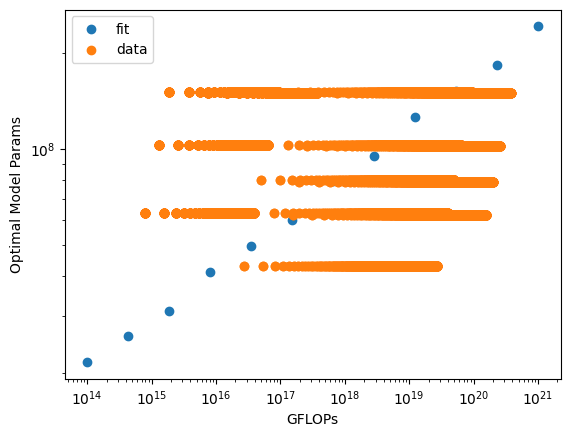

In [619]:
gs = []
ns = []
for gflops in gflops_grid:
    cc = CC[CC.gflops == gflops]
    idx = cc.pred.argmin()    
    gs.append(gflops)
    ns.append(cc.iloc[idx].N) 
plt.scatter(gs, ns, label="fit")
#pred_n = np.power(  ((alpha * A * np.power(gflops_grid, beta)) / (B * beta)), 1/(alpha+beta) )
#plt.scatter(gflops_grid, pred_n, c="red")
plt.xscale('log')
plt.yscale('log')
plt.scatter(G, N, label="data")
plt.legend()
plt.xlabel("GFLOPs")
plt.ylabel("Optimal Model Params")

Text(0, 0.5, 'Optimal Tokens Seen')

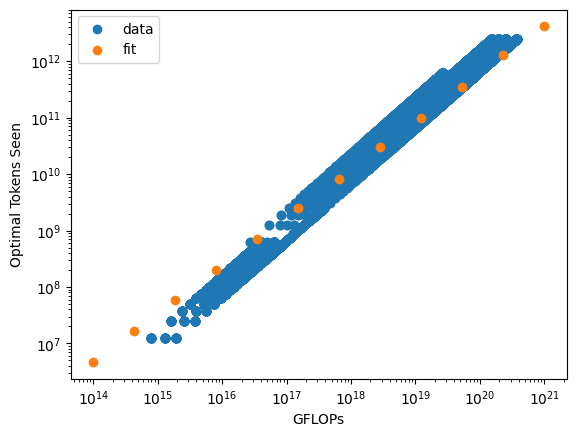

In [620]:
gs = []
ds = []
for gflops in gflops_grid:
    cc = CC[CC.gflops == gflops]
    idx = cc.pred.argmin()    
    gs.append(gflops)
    ds.append(cc.iloc[idx].D) 

#pred_n = np.power(  ((alpha * A * np.power(gflops_grid, beta)) / (B * beta)), 1/(alpha+beta) )
#plt.scatter(gflops_grid, pred_n, c="red")
plt.xscale('log')
plt.yscale('log')
plt.scatter(G, D, label="data")
plt.scatter(gs, ds, label="fit")
plt.legend()
plt.xlabel("GFLOPs")
plt.ylabel("Optimal Tokens Seen")

# Approach 1

<Axes: xlabel='gflops', ylabel='model_gflops'>

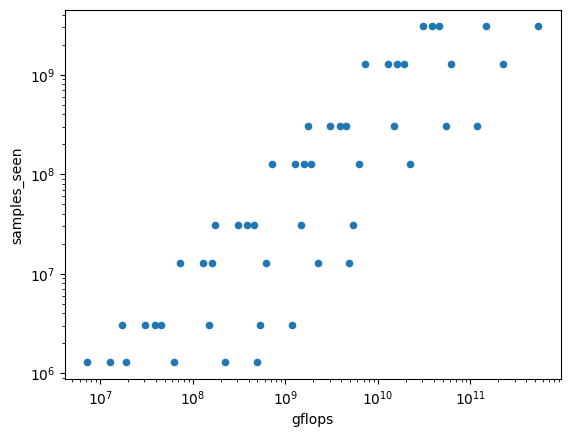

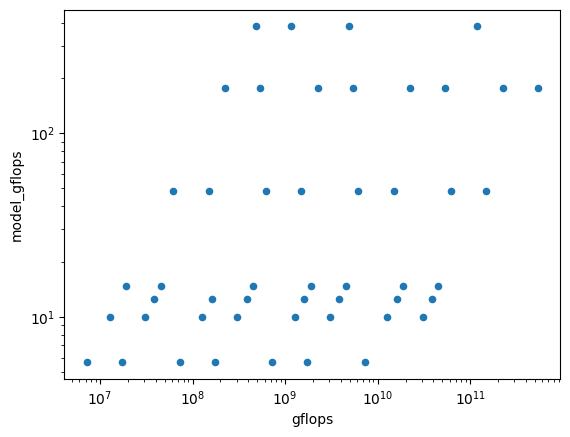

In [625]:

ds, metric = "imagenet1k", "acc1"
#ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
#ds, metric = "imagenet1k", "contrastive_loss"
D = df.copy()
scheduler = "cosine"
D = D[D.pretrain_dataset == "datacomp_1b"]
if scheduler != "const":
    D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
D = D[D.lr_scheduler == scheduler]
D = D[D.namespace == "clip"]
gflops_grid = np.logspace(  np.log10(D.gflops.min()), np.log10(D.gflops.max()), 100)
D["model_gflops"] = D.apply(lambda d:model_profile.loc[d.model].gflops , axis=1)
rows = []
for start, end in zip(gflops_grid[0:-1], gflops_grid[1:]):
    d = D[(D.gflops >= start) & (D.gflops < end)]
    if len(d):        
        di = d.iloc[d[metric].argmax()]
        rows.append({
            "gflops": di.gflops,
            "err":1-di[metric],
            "model": di.model,
            "model_mparams": model_profile.loc[di.model].mparams,
            "model_gflops": model_profile.loc[di.model].gflops,
            "samples_seen": di.samples_seen,
        })
df_envelope = pd.DataFrame(rows)
#df_envelope = df_envelope[df_envelope.err < 0.5]
#df_envelope = df_envelope.sort_values(by="gflops")
df_envelope.plot(x="gflops", y="samples_seen", kind="scatter", logx=True, logy=True)
df_envelope.plot(x="gflops", y="model_gflops", kind="scatter", logx=True, logy=True)

# Scaling Laws Summary Figure

In [ ]:
import matplotlib.colors as mcolors
# Define the start and end colors
start_color = "lightblue"  # or a hex like "#ADD8E6"
end_color = "darkblue"         # or a hex like "#0000FF"

# Create the colormap
blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "light_to_dark_blue", [start_color, end_color]
)
blue_cmap(200)

cmap = plt.get_cmap("Blues")


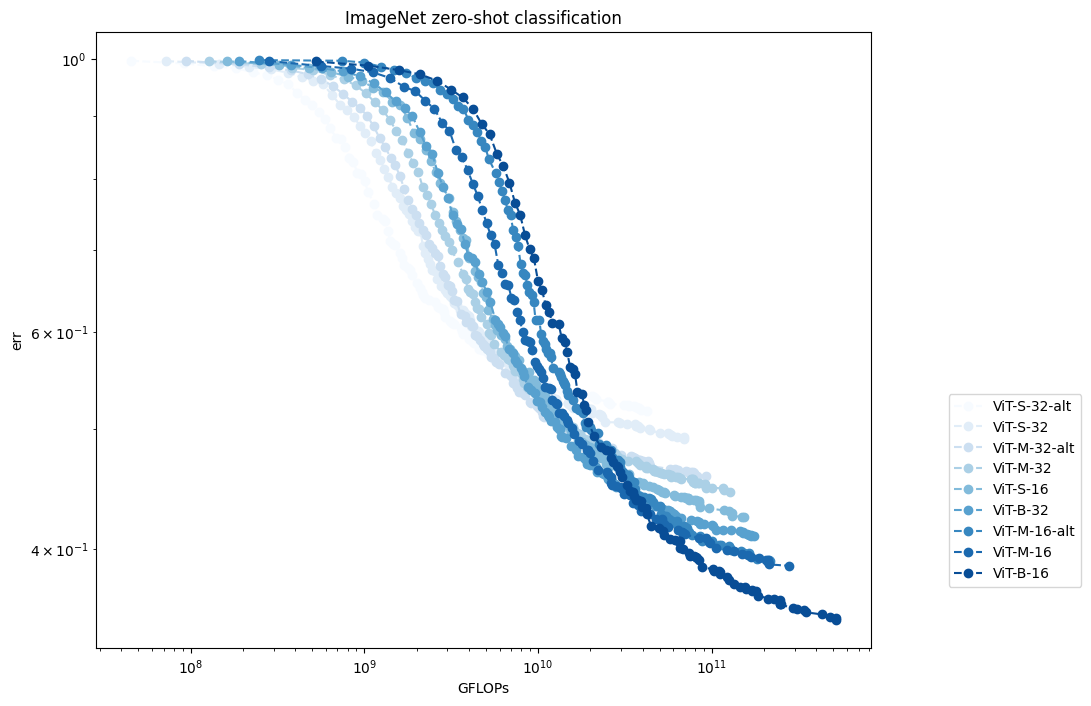

In [62]:
ds, metric = "imagenet1k", "acc1"
#ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
scheduler = "const"
D = df
D = D[D.pretrain_dataset == "datacomp_1b"]

D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
D = D[D.namespace == "clip"]
D = D[D.lr_scheduler == scheduler]
if scheduler != "const":
    D = D[D.epoch==D.total_epochs]
N = len(D.model.unique())
models = list(D.model.unique())
models = sorted(models, key=lambda k:model_profile.loc[k].gflops)
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
#for ind, (name, rows) in enumerate(D.groupby(["model"])):

for ind, model in enumerate(models):
    rows = D[D.model == model]
    name = rows.model.values[0]
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    R = rows
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    if scheduler == "const":
        R["gflops_total"] = R.epoch * 12.8e6 * model_profile.loc[model].gflops
    R = R.sort_values(by="gflops_total")

    X = (R["gflops_total"]).values
    #X = R["total_samples_seen"].values
    Y = 1-(R[metric]).values


    #color = "blue"
    
    I+=1
    #m = (X>=10**9)# & (X < 10**12)
    #m = (X<10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    #print(np.unique(X))
    #for xi in np.unique(X):
    #    minval = Y[X==xi].min()
    #    Y[X==xi] = minval
    #m=(Y<=0.9) & (Y>0)

    #plt.plot(X[m], func(X[m]), label=f"{name}", linestyle='dashed', c=color)
    #m = monotonically_decreasing2(X, Y)
    #m = monotonically_decreasing(Y)
    #m = X>0
    #plt.scatter(X, Y, label=f"{name[0]}", c=color, s=10.0, alpha=0.5)
    XX, YY = group_vals(X, Y)
    m = monotonically_decreasing(YY)
    plt.plot(XX[m], YY[m], linestyle='dashed', c=cmap(  (I-1) / N), marker='o', label=f"{name}")
plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
plt.legend(loc=(1.1,.1))

#plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()